## KG Inference and RAG

In this notebook we are going to compare 2 strategy:
- KG-RAG: Retrieving **structured** data from the KG and answering question
- Vanilla-RAG: Retrieving **unstructured** data from the raw text and answering questions.

What are the strengh of both strategies and when we should apply them.

In [ ]:
# Standard setup for participants
!pip install neo4j pandas dspy

In [ ]:
# =============================================================================
# 1. CONNECTION SETUP
# =============================================================================
# Replace with your Neo4j Aura credentials
NEO4J_URI = "neo4j+s://1c51a1ef.databases.neo4j.io"  # Note: neo4j+s for Aura
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "LwJT5kjrM1dX5ntarTB0XRY8LCrfBqoOA0_IRjRLGOg"

In [ ]:
from neo4j import GraphDatabase
class Neo4jLoader:
  def __init__(self, uri, user, password):
    self.driver = GraphDatabase.driver(uri, auth=(user, password))
    self.test_connection()

  def test_connection(self):
    """
    Just a simple test for the connection
    """
    with self.driver.session() as session:
        result = session.run("RETURN 'Connection successful!' as message")
        return result.single()["message"]

  def close(self):
    """
    Close the driver connection
    """
    self.driver.close()

  def execute_query(self, cypher_query, parameters=None):
    """
    Execute a Cypher query and return all results

    Args:
        cypher_query (str): The Cypher query to execute
        parameters (dict, optional): Parameters for the query

    Returns:
        list: List of records from the query result
    """
    with self.driver.session() as session:
        result = session.run(cypher_query, parameters or {})
        return [record for record in result]




In [ ]:
loader = Neo4jLoader(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)

### Dracorhodin perchlorate was tested for treatment of which cancers ?

In [ ]:
a_simple_query = """
MATCH (c:Chemical)-[r:treat]->(d:Disease)
WHERE 'dracorhodin perchlorate' IN c.alt_names
RETURN d.name
"""
loader.execute_query(a_simple_query)

# Can also check with Teplizumab ... We should find Diabetes !

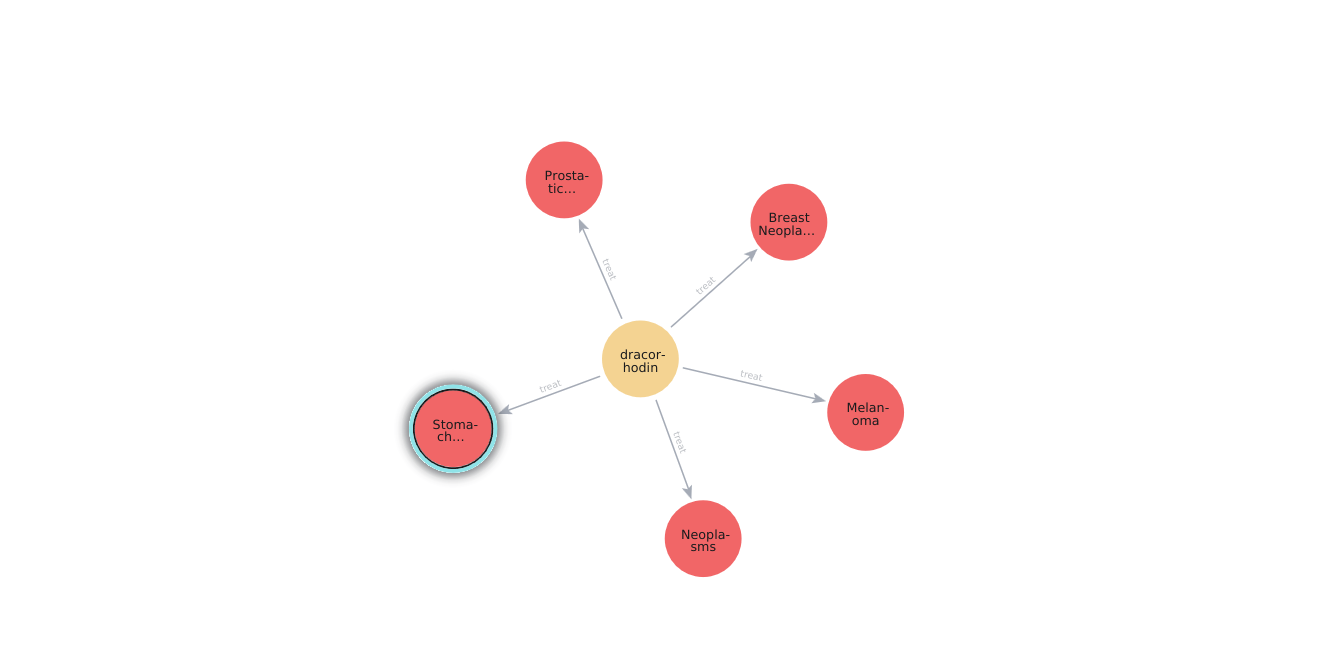

### Which genes have been associated with Cerebral Cavernous Malformation ?

In [ ]:
a_simple_query = """
MATCH (g:Gene)-[r]-(d:Disease)
WHERE 'Cerebral cavernous malformation' IN d.alt_names
RETURN g.name, type(r)
"""
loader.execute_query(a_simple_query)

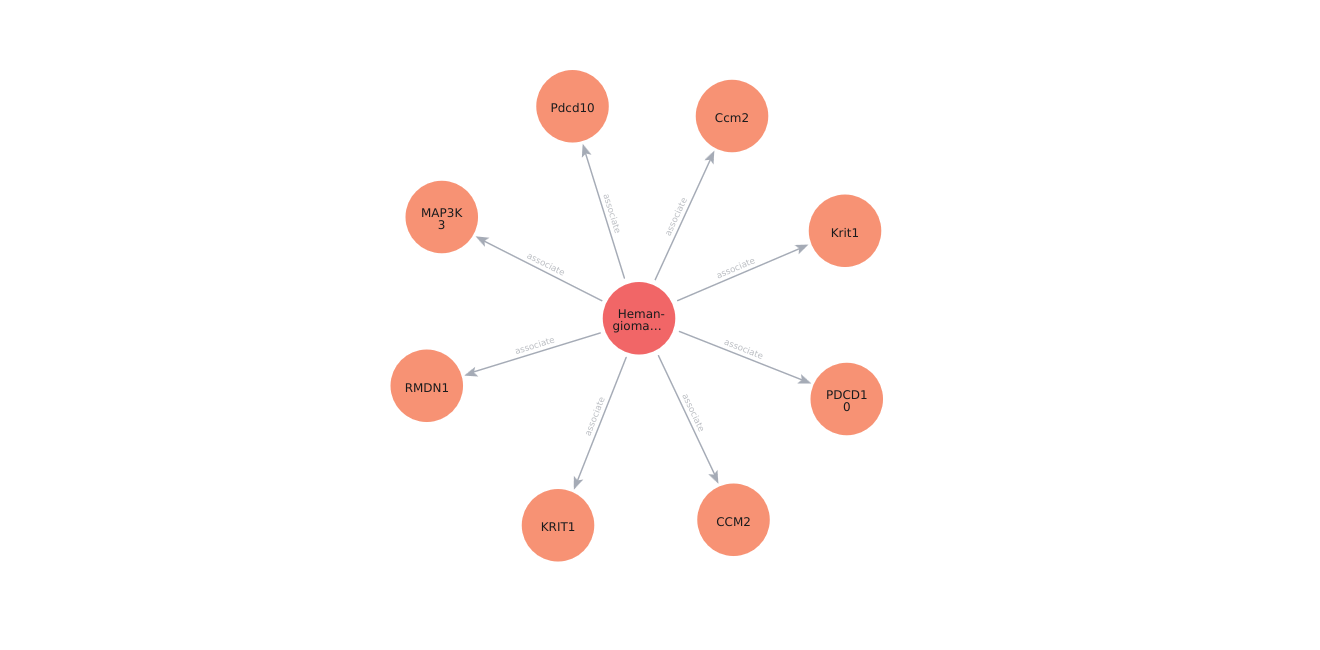

### Finding toxicity related chemicals

In [ ]:
a_query = """
MATCH (g:Gene)<-[r:associate]-(d:Disease)<-[r2:cause]-(c:Chemical)
MATCH (c)-[r3:negative_correlate]-(g)
RETURN g.name, d.name, c.name
"""
loader.execute_query(a_query)

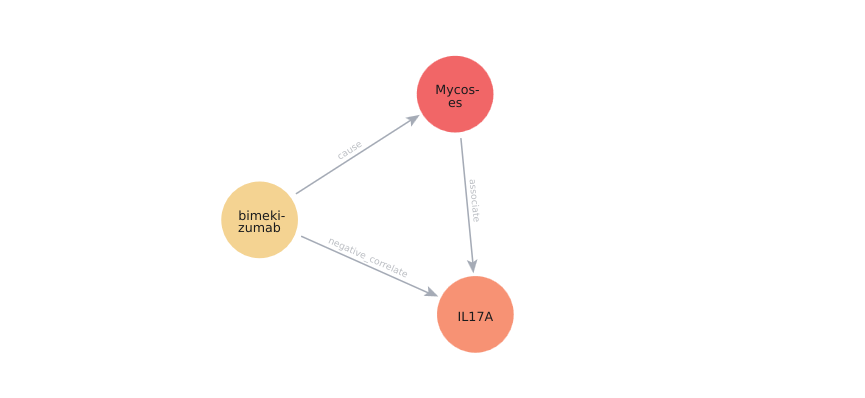

### What drugs are treating diseases associated to mutations of IL17A ?

In [ ]:
a_query = """
MATCH (g:Gene {name: "IL17A"})<-[r1:associate]-(d:Disease)<-[r2:treat]-(c:Chemical)
RETURN DISTINCT c.name AS chemical, d.name AS disease
"""
loader.execute_query(a_query)

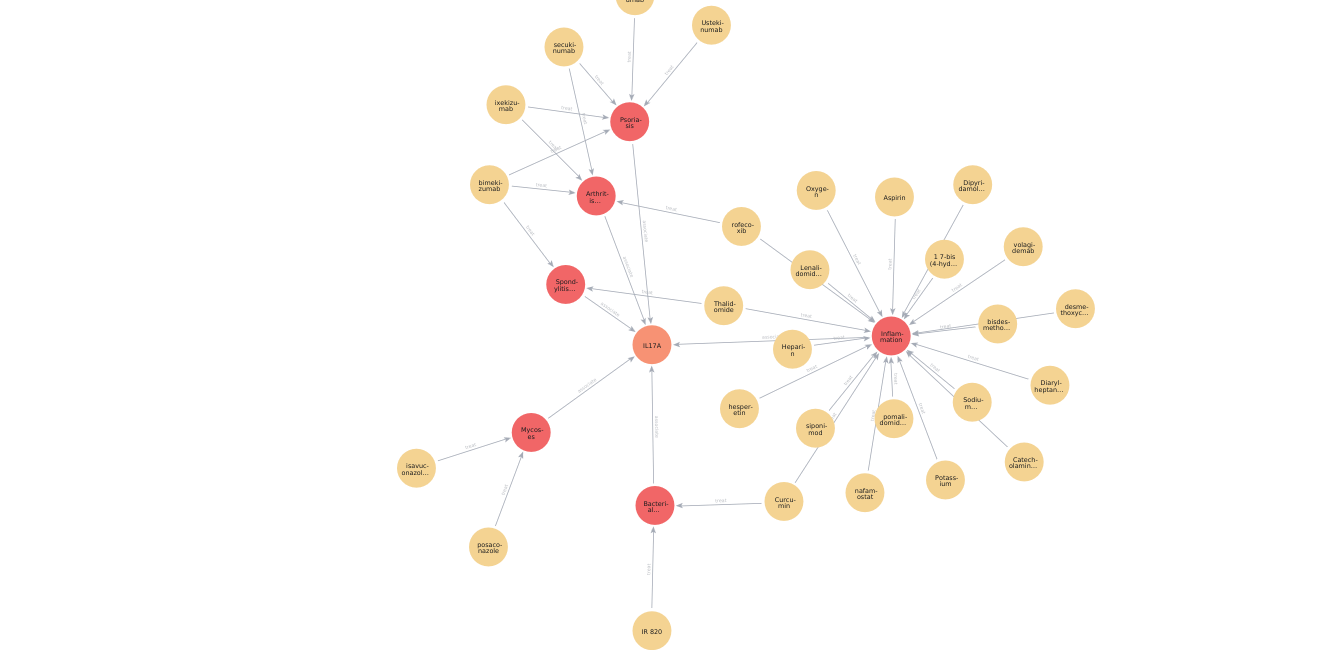

### Hypothesis discovery: find all Genes (g1) for which other associated genes (g2) are associated to a disease (d), but (g1) is not associated to (d).

*Friend of a friend hypothesis*

In [ ]:
a_query = """
MATCH (g1:Gene)-[:associate]-(g2:Gene)-[:associate]-(d:Disease)
WHERE NOT (g1)-[:associate]->(d)
WITH g1, d, count(g2) AS shared_intermediaries
ORDER BY shared_intermediaries DESC
RETURN g1.name AS gene_name, d.name AS disease_name, shared_intermediaries
"""
loader.execute_query(a_query)


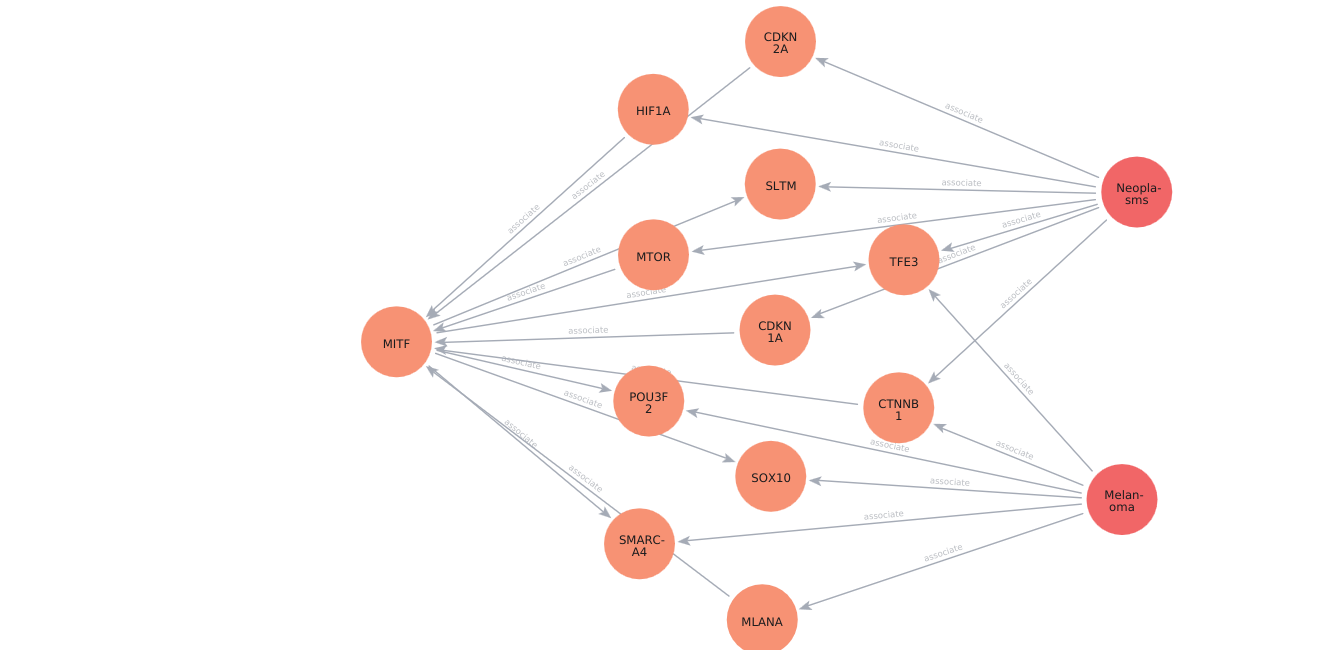

## KG base Information Retrieval

## Design of a KG-RAG

In [ ]:
import dspy
class PromptDiseaseAssociatedChemicals(dspy.Signature):
    """
    The user is looking for diseases treated by a defined chemical. You will recieved a list of diseases extracted from a KG. Provide an answer with all diseases.
    If the list of diseases is empty, return "No diseases found".
    """
    chemical: str = dspy.InputField(desc="The target chemical")
    diseases: list[str] = dspy.InputField(desc="The list of diseases")
    answer: str = dspy.OutputField(desc="The answer")


class QuestionToCypher(dspy.Signature):
    """Convert a natural language question about biomedical entities into a Cypher query for Neo4j knowledge graph.

    The knowledge graph contains biomedical entities (Gene, Disease, Chemical, Variant, Species, Cell Line)
    and relationships (associate, cause, compare, cotreat, drug_interact, inhibit, interact, negative_correlate, positive_correlate, prevent, stimulate, treat) from PubMed literature.

    The relation 'associate' is not directed.

    Generate syntactically correct Cypher queries that match the question's intent.
    Use appropriate node labels, relationship types, and property filters.
    """

    question = dspy.InputField(desc="Natural language question about biomedical entities and relationships")
    cypher_query = dspy.OutputField(desc="Cypher query to answer the question")

class GenerateAnswer(dspy.Signature):
    """Generate a comprehensive answer to a biomedical question using query results from a knowledge graph.

    Synthesize the provided query results into a clear, informative response that directly addresses
    the original question. Include relevant details from the results and explain the biomedical context.
    """

    question = dspy.InputField(desc="Original natural language question")
    query_results = dspy.InputField(desc="Results from the Cypher query execution")
    answer = dspy.OutputField(desc="Comprehensive answer synthesizing the query results")

class DAC(dspy.Module):
    def __init__(self):
        super().__init__()
        self.extract = dspy.Predict(PromptDiseaseAssociatedChemicals)

    def forward(self, chemical, diseases):
        """Extract entities and relations from PubMed title and abstract"""
        result = self.extract(chemical=chemical, diseases=diseases)
        return result.answer


In [ ]:

from neo4j import GraphDatabase
import os
from dotenv import load_dotenv, find_dotenv


# load .env vars
_ = load_dotenv(find_dotenv())

# Configuration class for different LLM backends
class LLMConfig:
    @staticmethod
    def setup_openai(api_key: str, model: str = "gpt-4.1-mini", max_tokens=2048):
        """Setup OpenAI API"""
        import openai
        openai.api_key = api_key
        lm = dspy.LM(model, max_tokens=max_tokens)
        dspy.configure(lm=lm, adapter=dspy.JSONAdapter())
        dspy.settings.lm.kwargs["temperature"] = 0.0
        return lm

    @staticmethod
    def setup_ollama(api_base: str = "http://127.0.0.1:11434", model: str = "llama3.1:8b", max_tokens=2048):
        """Setup Ollama local model"""
        lm = dspy.LM(model, api_base=api_base, max_tokens=max_tokens)
        dspy.configure(lm=lm, adapter=dspy.JSONAdapter())
        dspy.settings.lm.kwargs["temperature"] = 0.0
        return lm

class KGAG:
    def __init__(self, uri, user, password, llm_type="openai", **kwargs):
      self.driver = GraphDatabase.driver(uri, auth=(user, password))
      self.test_connection()
      self.llm_type = llm_type

      if llm_type == "openai":
          api_key = kwargs.get("api_key", os.getenv("OPENAI_API_KEY"))
          model = kwargs.get("model", "gpt-4-turbo-preview")
          self.lm = LLMConfig.setup_openai(api_key, model)
      elif llm_type == "ollama":
          model = kwargs.get("model", "llama3.1:8b")
          base_url = kwargs.get("base_url", "http://127.0.0.1:11434")
          print(f"model: {model} / base_url: {base_url}")
          self.lm = LLMConfig.setup_ollama(base_url, model)

      # The RAG modules
      # simple pattern
      self.dac = DAC()
      # auto-generated queries and answer.
      self.question_to_cypher = dspy.Predict(QuestionToCypher)
      self.generate_answer = dspy.Predict(GenerateAnswer)


    def test_connection(self):
        """
        Just a simple test for the connection
        """
        with self.driver.session() as session:
            result = session.run("RETURN 'Connection successful!' as message")
            return result.single()["message"]

    def close(self):
        """
        Close the driver connection
        """
        self.driver.close()

    def execute_query(self, cypher_query, parameters=None):
        """
        Execute a Cypher query and return all results

        Args:
            cypher_query (str): The Cypher query to execute
            parameters (dict, optional): Parameters for the query

        Returns:
            list: List of records from the query result
        """
        with self.driver.session() as session:
            result = session.run(cypher_query, parameters or {})
            return [record for record in result]

    def find_disease_treatment(self, chemical_name):
        query = """MATCH (c:Chemical)-[r:treat]->(d:Disease)
        WHERE '{chemical_name}' IN c.alt_names
        RETURN d.name""".format(chemical_name=chemical_name)
        response = self.execute_query(query)
        diseases = [record["d.name"] for record in response]

        return self.dac(chemical_name, diseases)

    def qa(self, question):
        """
        Forward pass through the complete pipeline

        Args:
            question (str): Natural language question about biomedical entities

        Returns:
            dspy.Prediction: Prediction object with question, cypher_query, query_results, and answer
        """
        try:
            # Step 1: Convert question to Cypher query
            cypher_result = self.question_to_cypher(question=question)
            cypher_query = cypher_result.cypher_query
            print("#" * 50)
            print(f"{question}:\n{cypher_query}")
            print("#" * 50)

            # Step 2: Execute the Cypher query
            query_results = self.execute_query(cypher_query)
            print("#" * 50)
            print(f"Cypher results:\n{query_results}")
            print("#" * 50)

            # Step 3: Generate answer from results
            results_text = str(query_results) if query_results else "No results found"
            answer_result = self.generate_answer(question=question, query_results=results_text)

            output = dspy.Prediction(
                question=question,
                cypher_query=cypher_query,
                query_results=query_results,
                answer=answer_result.answer
            )
            print(print("#" * 50))
            print(f"answer:\n{output.answer}")
            print(print("#" * 50))

        except Exception as e:
            return dspy.Prediction(
                question=question,
                cypher_query=None,
                query_results=None,
                answer=f"Error processing question: {str(e)}"
            )

### Using some pre-defined query templates

If there is a predefined set of queries a user should be able to ask, then creating predefined query templates is a robust solution.

In [ ]:
kgrag = KGAG(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD, model="gpt-4.1-mini")

In [ ]:
kgrag.find_disease_treatment(chemical_name="Teplizumab")

### Letting the LLM infer the query: End to End Question Answering

In an open setting, the user should only come with a question, without expecting him to know how to formulate the Graph Query (Cypher or SPARQL). Then, we can let the model infer the query.

But how does the LLM knows about the KG schema ?

Well, a naive implementation will prompt it with a description of the KG. For instance:
```
Convert a natural language question about biomedical entities into a Cypher query for Neo4j knowledge graph.

The knowledge graph contains biomedical entities (Gene, Disease, Chemical, Variant, Species, Cell Line)
and relationships (associate, cause, compare, cotreat, drug_interact, inhibit, interact, negative_correlate, positive_correlate, prevent, stimulate, treat) from PubMed literature.

The relation 'associate' is not directed.

Generate syntactically correct Cypher queries that match the question's intent.
Use appropriate node labels, relationship types, and property filters.
```

But is it sufficient? what happens on a complex KG ? how to deal with entity Matching ?

[*Biomedical knowledge graph-optimized prompt generation for large language models*](https://doi.org/10.1093/bioinformatics/btae560)

#### Classic QA

In [ ]:
kgrag.qa("What diseases are treated by the chemical teplizumab (only return their names?")

In [ ]:
kgrag.qa("Which genes have been associated with 'Hemangioma Cavernous Central Nervous System' ?")

- Is the output format a Graph query good for an LLM ? Can we verbalised it ?
- Strong reliance on the schema -> there is no learning of the schema.

#### Some more global queries

In [ ]:
kgrag.qa("What is the mechanism of action of PRO051 ?")

# RAG

## Settings

In [ ]:
# run this in case all dependencies are not yet installed.
!pip install chromadb sentence-transformers dspy-ai openai python-dotenv

In [ ]:
import json
import os
from typing import List, Dict, Any, Optional
import dspy
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
import openai
from dotenv import load_dotenv
from IPython.display import display, HTML, Markdown

# Load environment variables (for API keys)
load_dotenv()

# Configuration class for different LLM backends
class LLMConfig:
    @staticmethod
    def setup_openai(api_key: str, model: str = "gpt-4.1-mini", max_tokens=2048):
        """Setup OpenAI API"""
        import openai
        openai.api_key = api_key
        lm = dspy.LM(model, max_tokens=max_tokens)
        dspy.configure(lm=lm, adapter=dspy.JSONAdapter())
        dspy.settings.lm.kwargs["temperature"] = 0.0
        return lm

    @staticmethod
    def setup_ollama(api_base: str = "http://127.0.0.1:11434", model: str = "llama3.1:8b", max_tokens=2048):
        """Setup Ollama local model"""
        lm = dspy.LM(model, api_base=api_base, max_tokens=max_tokens)
        dspy.configure(lm=lm, adapter=dspy.JSONAdapter())
        dspy.settings.lm.kwargs["temperature"] = 0.0
        return lm

class RAGConfig:
    """Configuration class for our RAG system"""

    def __init__(self,
                 embedding_model: str = "BAAI/bge-large-en-v1.5",
                 collection_name: str = "pubmed_abstracts",
                 llm_type: str = "openai",
                 llm_model = "gpt-4.1-nano",
                 base_url="http://127.0.0.1:11434",
                 api_key: Optional[str] = None,
                 **kwargs):

        self.embedding_model = embedding_model
        self.collection_name = collection_name
        self.llm_type = llm_type

        if llm_type == "openai":
            api_key = kwargs.get("api_key", os.getenv("OPENAI_API_KEY"))
            self.lm = LLMConfig.setup_openai(api_key, llm_model)
        elif llm_type == "ollama":
            print(f"model: {llm_model} / base_url: {base_url}")
            self.lm = LLMConfig.setup_ollama(base_url, llm_model)

class DocumentProcessor:
    """Handles document processing and embedding generation"""

    def __init__(self, embedding_model_name: str):
        self.embedding_model = SentenceTransformer(embedding_model_name)
        print(f"Embedding model loaded: {embedding_model_name}")

    def process_documents(self, json_documents: List[Dict]) -> tuple:
        """
        Process JSON documents and prepare them for vector storage

        Args:
            json_documents: List of document dictionaries with 'pmid' and 'text'

        Returns:
            Tuple of (texts, embeddings, metadatas, ids)
        """
        texts = []
        metadatas = []
        ids = []

        print(f"Processing {len(json_documents)} documents...")

        for doc in json_documents:
            pmid = doc.get('pmid', 'unknown')
            text = doc.get('text', '')

            if text.strip():  # Only process non-empty texts
                texts.append(text)
                metadatas.append({
                    'pmid': pmid,
                    'length': len(text)
                })
                ids.append(f"doc_{pmid}")

        print(f"Generating embeddings for {len(texts)} documents...")
        embeddings = self.embedding_model.encode(texts, show_progress_bar=True)

        return texts, embeddings.tolist(), metadatas, ids

class VectorDatabase:
    """Manages ChromaDB operations"""

    def __init__(self, collection_name: str):
        self.collection_name = collection_name

        # Initialize ChromaDB client
        self.client = chromadb.PersistentClient(
            path="./chroma_db"
        )

        # Create or get collection
        try:
            self.collection = self.client.create_collection(
                name=collection_name,
                metadata={"hnsw:space": "cosine"}
            )
            print(f"Created new collection: {collection_name}")
        except:
            self.collection = self.client.get_collection(name=collection_name)
            print(f"Using existing collection: {collection_name}")

    def add_documents(self, texts: List[str], embeddings: List[List[float]],
                     metadatas: List[Dict], ids: List[str]):
        """Add documents to the vector database"""

        print(f"Adding {len(texts)} documents to ChromaDB...")

        self.collection.add(
            documents=texts,
            embeddings=embeddings,
            metadatas=metadatas,
            ids=ids
        )

        print(f"Successfully added {len(texts)} documents to the database")

    def search(self, query_embedding: List[float], top_k: int = 5) -> Dict:
        """Search for similar documents"""

        results = self.collection.query(
            query_embeddings=[query_embedding],
            n_results=top_k,
            include=["documents", "metadatas", "distances"]
        )

        return results

class RetrievalSignature(dspy.Signature):
    """Signature for the retrieval component"""
    query = dspy.InputField(desc="User's question or search query")
    context = dspy.InputField(desc="Retrieved relevant document chunks")
    answer = dspy.OutputField(desc="Comprehensive answer based on the context")

class RAGModule(dspy.Module):
    """Main RAG module using DSPy"""

    def __init__(self, vector_db: VectorDatabase, embedding_model: SentenceTransformer):
        super().__init__()
        self.vector_db = vector_db
        self.embedding_model = embedding_model

        # DSPy components
        self.generate_answer = dspy.ChainOfThought(RetrievalSignature)

    def retrieve(self, query: str, top_k: int = 5) -> tuple:
        """Retrieve relevant documents for a query"""

        # Generate query embedding
        query_embedding = self.embedding_model.encode([query])[0].tolist()

        # Search vector database
        results = self.vector_db.search(query_embedding, top_k)

        # Format retrieved documents
        retrieved_docs = []
        for i in range(len(results['documents'][0])):
            doc_info = {
                'content': results['documents'][0][i],
                'pmid': results['metadatas'][0][i]['pmid'],
                'distance': results['distances'][0][i],
                'relevance_score': 1 - results['distances'][0][i]  # Convert distance to relevance
            }
            retrieved_docs.append(doc_info)

        return retrieved_docs, results

    def forward(self, query: str, top_k: int = 5):
        """Main forward pass of the RAG system"""

        # Step 1: Retrieve relevant documents
        retrieved_docs, raw_results = self.retrieve(query, top_k)

        # Step 2: Prepare context for LLM
        context_parts = []
        for i, doc in enumerate(retrieved_docs):
            context_parts.append(f"Document {i+1} (PMID: {doc['pmid']}):\n{doc['content']}")

        context = "\n\n".join(context_parts)

        # Step 3: Generate answer using DSPy
        prediction = self.generate_answer(query=query, context=context)

        return dspy.Prediction(
            answer=prediction.answer,
            retrieved_docs=retrieved_docs,
            context=context,
            query=query
        )



class PubMedRAG:
    """Complete RAG system for PubMed"""

    def __init__(self, config: RAGConfig):
        self.config = config

        # Initialize components
        self.doc_processor = DocumentProcessor(config.embedding_model)
        self.vector_db = VectorDatabase(config.collection_name)
        self.rag_module = RAGModule(self.vector_db, self.doc_processor.embedding_model)

        print("RAG System initialized successfully!")

    def load_documents(self, json_file_path: str = None, json_data: List[Dict] = None):
        """Load documents from JSON file or data"""

        if json_file_path:
            print(f"Loading documents from {json_file_path}...")
            with open(json_file_path, 'r', encoding='utf-8') as f:
                documents = json.load(f)
        elif json_data:
            print("Loading documents from provided data...")
            documents = json_data
        else:
            raise ValueError("Either json_file_path or json_data must be provided")

        # Process documents
        texts, embeddings, metadatas, ids = self.doc_processor.process_documents(documents)

        # Add to vector database
        self.vector_db.add_documents(texts, embeddings, metadatas, ids)

        return len(documents)

    def search(self, query: str, top_k: int = 5) -> Dict[str, Any]:
        """Search the knowledge base and generate an answer"""

        print(f"Searching for: '{query}' (top_k={top_k})")

        # Get prediction from RAG module
        prediction = self.rag_module(query, top_k)

        # Format response
        response = {
            'query': query,
            'answer': prediction.answer,
            'retrieved_documents': [
                {
                    'pmid': doc['pmid'],
                    'content': doc['content'],
                    'full_content': doc['content'],
                    'relevance_score': round(doc['relevance_score'], 4)
                }
                for doc in prediction.retrieved_docs
            ],
            'top_k': top_k
        }

        # display the answer nicely
        markdown_content = f"**Question:** {response['query']}\n\n\n**Answer**:{response['answer']}\n**Retrieved Documents**:\n"

        for i, doc in enumerate(response['retrieved_documents'], 1):
            markdown_content += f"""
        Document {i} - PMID: {doc['pmid']} (Relevance: {doc['relevance_score']:.3f})
        {doc['content']}

        """
        display(Markdown(markdown_content))
        return response




## Indexing

In [ ]:
config = RAGConfig(llm_type="openai",
        api_key=os.getenv("OPENAI_API_KEY"),
        embedding_model="BAAI/bge-large-en-v1.5",
        llm_model="gpt-4.1-nano"
    )
rag_system = PubMedRAG(config)
# num_docs = rag_system.load_documents(json_file_path="/content/documents_texts_with_pmid.json")

## QA

### Factual QA

In [ ]:
response = rag_system.search("Dracorhodin perchlorate was tested for treatment of which cancers ?", top_k=3)

In [ ]:
response = rag_system.search("Which genes have been associated with Cerebral Cavernous Malformation ?", top_k=3)

In [ ]:
response = rag_system.search("What drugs are treating diseases associated to mutations of IL17A ?", top_k=3)

### A more global QA:

In [ ]:
response = rag_system.search("What is the mechanism of action of drisapersen ?")